# Loan Approval Prediction: EDA and Model Training

### Part 1: Data Loading & Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the dataset
df = pd.read_csv('../data/loan_prediction_dataset.csv')

#### Initial Inspection

In [2]:
print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the dataset:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural      

In [3]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


#### Data Visualization

C:\Users\nethm\AppData\Local\Temp\ipykernel_11780\470002018.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Loan_Status', data=df, palette='viridis')


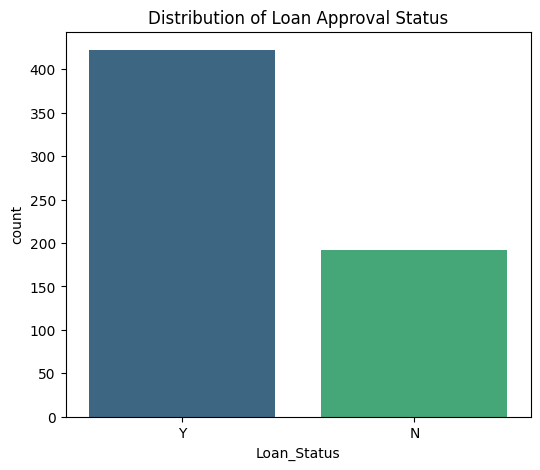

In [4]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Loan_Status', data=df, palette='viridis')
plt.title('Distribution of Loan Approval Status')
plt.show()

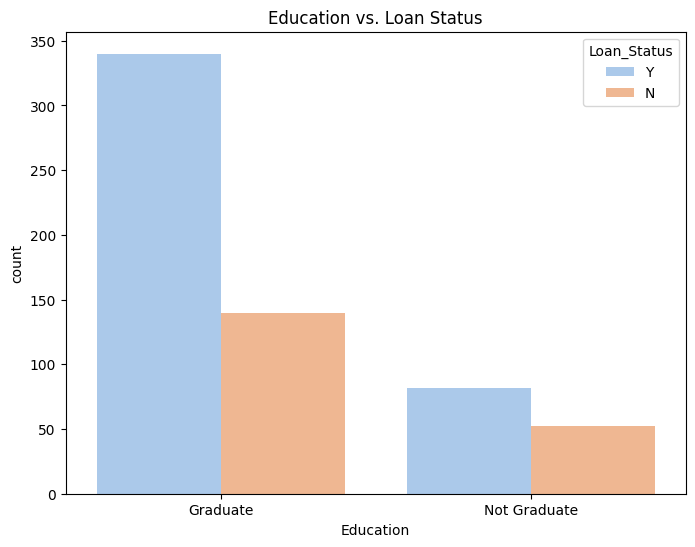

In [5]:
# Explore relationships between features and the target
plt.figure(figsize=(8, 6))
sns.countplot(x='Education', hue='Loan_Status', data=df, palette='pastel')
plt.title('Education vs. Loan Status')
plt.show()

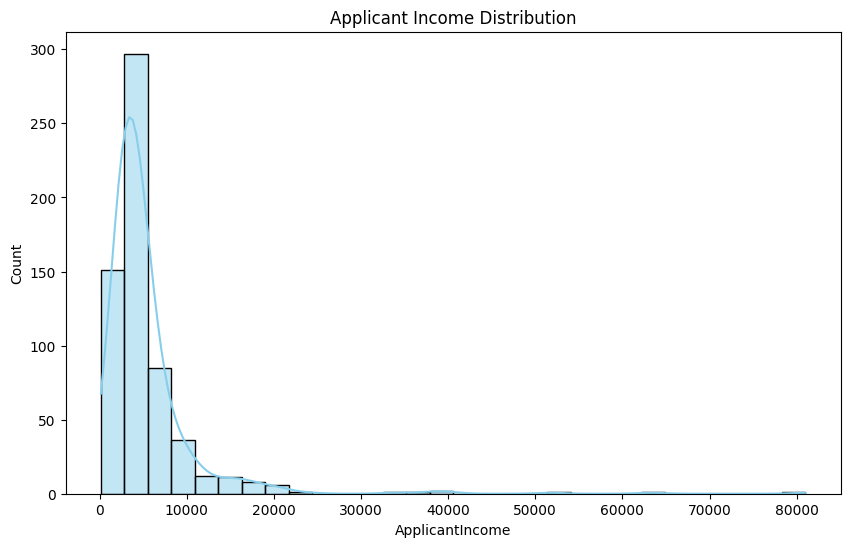

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ApplicantIncome'], bins=30, kde=True, color='skyblue')
plt.title('Applicant Income Distribution')
plt.show()

### Part 2: Data Preprocessing & Feature Engineering

#### Handle Missing Values

In [7]:
# For numerical columns, use the median for robustness to outliers
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].median())

# For categorical columns, use the mode (most frequent value)
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

# Verify that all missing values are handled
print("Missing values after handling:")
print(df.isnull().sum())

Missing values after handling:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


#### Encode Categorical Variables

In [8]:
# Convert target variable first
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Use one-hot encoding for other categorical features
df_encoded = pd.get_dummies(df, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)

print("Data shape after encoding:", df_encoded.shape)
df_encoded.head()

Data shape after encoding: (614, 16)


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,5849,0.0,128.0,360.0,1.0,1,True,False,False,False,False,False,False,False,True
1,LP001003,4583,1508.0,128.0,360.0,1.0,0,True,True,True,False,False,False,False,False,False
2,LP001005,3000,0.0,66.0,360.0,1.0,1,True,True,False,False,False,False,True,False,True
3,LP001006,2583,2358.0,120.0,360.0,1.0,1,True,True,False,False,False,True,False,False,True
4,LP001008,6000,0.0,141.0,360.0,1.0,1,True,False,False,False,False,False,False,False,True


#### Feature Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

# Drop Loan_ID as it's not a predictive feature
df_encoded = df_encoded.drop('Loan_ID', axis=1)

X = df_encoded.drop('Loan_Status', axis=1)
y = df_encoded['Loan_Status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0.072991,-0.554487,-0.211241,0.273231,0.411733,0.472343,-1.372089,-0.446339,-0.443713,-0.300975,-0.528362,-0.392601,-0.782016,1.428147
1,-0.134412,-0.038732,-0.211241,0.273231,0.411733,0.472343,0.728816,2.240448,-0.443713,-0.300975,-0.528362,-0.392601,-0.782016,-0.700208
2,-0.393747,-0.554487,-0.948996,0.273231,0.411733,0.472343,0.728816,-0.446339,-0.443713,-0.300975,-0.528362,2.547117,-0.782016,1.428147
3,-0.462062,0.251980,-0.306435,0.273231,0.411733,0.472343,0.728816,-0.446339,-0.443713,-0.300975,1.892641,-0.392601,-0.782016,1.428147
4,0.097728,-0.554487,-0.056551,0.273231,0.411733,0.472343,-1.372089,-0.446339,-0.443713,-0.300975,-0.528362,-0.392601,-0.782016,1.428147


### Part 3: Model Training & Evaluation

#### Split the Data

In [10]:
from sklearn.model_selection import train_test_split

# stratify=y ensures the proportion of 'Y' and 'N' is the same in both the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Train and Evaluate Models

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Logistic Regression ---
print("--- Logistic Regression ---")
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

# --- Random Forest ---
print("\n--- Random Forest ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# --- XGBoost ---
print("\n--- XGBoost ---")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

--- Logistic Regression ---
Accuracy: 0.8617886178861789
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123


--- Random Forest ---
Accuracy: 0.8373983739837398
              precision    recall  f1-score   support

           0       0.80      0.63      0.71        38
           1       0.85      0.93      0.89        85

    accuracy                           0.84       123
   macro avg       0.82      0.78      0.80       123
weighted avg       0.83      0.84      0.83       123


--- XGBoost ---
Accuracy: 0.7723577235772358
              precision    recall  f1-score   support

           0       0.63      0.63      0.63        38
           1       0.84      0.84      0.84        85

    accuracy               

C:\Users\nethm\Music\credit-risk-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:54:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Part 4: Model Selection & Saving

In [12]:
# Based on the results, Logistic Regression and Random Forest perform very well.
# Let's choose Random Forest as it's often more robust.

# Ensure the 'app' directory exists
import os
if not os.path.exists('../app'):
    os.makedirs('../app')

# Save the model, scaler, and column order to the 'app' directory
joblib.dump(rf, '../app/random_force_model.pkl')
joblib.dump(scaler, '../app/scaler.pkl')
joblib.dump(X.columns, '../app/model_columns.pkl')

print("Model, scaler, and columns saved successfully in the 'app' directory.")

Model, scaler, and columns saved successfully in the 'app' directory.
